# Rakuten Images challenge

## Imports, Initial exploration of Rakuten Images and class_weights

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# fastai
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

# Others
import math
import subprocess
import cv2
from operator import itemgetter

In [4]:
path = Path('data')
train_path = path / 'training-data'
train_path.ls()

[PosixPath('data/training-data/train.csv'),
 PosixPath('data/training-data/class-mapping.csv'),
 PosixPath('data/training-data/train-images')]

In [5]:
df = pd.read_csv(train_path / 'train.csv', names=['filename', 'tag'])
df.head(20)

,filename,tag
0,1000000965.jpg,40
1,1310005493.jpg,31
2,1050002320.jpg,37
3,1340001721.jpg,33
4,1650001155.jpg,3
5,1170004207.jpg,37
6,1010005392.jpg,26
7,1750014800.jpg,33
8,1620005640.jpg,19
9,1760020112.jpg,3


In [6]:
filenames = df['filename'].values
files_in_path = (train_path / 'train-images').ls()
files_in_path_names = list()
for i, f in enumerate(files_in_path):
    files_in_path_names.append(files_in_path[i].name)

In [7]:
extra_files = list(set(files_in_path_names) - set(filenames))
print(len(filenames), len(files_in_path), len(extra_files))

for i in range(len(extra_files)):
    subprocess.call(['rm', str(train_path / 'train-images' / extra_files[i])])

554656 554656 0


In [8]:
tags = df['tag'].values
unique, counts = np.unique(tags, return_counts=True)
print(dict(zip(unique, counts)), "\nSum:", counts.sum())

{0: 1529, 1: 13502, 2: 39805, 3: 37365, 4: 3701, 5: 30075, 6: 277, 7: 3334, 8: 563, 9: 1074, 10: 11522, 11: 10394, 12: 13681, 13: 30485, 14: 418, 15: 2170, 16: 22084, 17: 2003, 18: 7813, 19: 1417, 20: 14044, 21: 463, 22: 19664, 23: 3827, 24: 1507, 25: 543, 26: 386, 27: 5998, 28: 26737, 29: 306, 30: 250, 31: 1428, 32: 5620, 33: 43691, 34: 781, 35: 357, 36: 4122, 37: 127135, 38: 3079, 39: 1982, 40: 15093, 41: 26826, 42: 17605} 
Sum: 554656


In [9]:
total_train_set_len = len(tags)
idx_to_count_and_per= dict()

for u, c in zip(unique, counts):
    per = (c * 100) / total_train_set_len
    idx_to_count_and_per[u] = (c, per)

idx_to_count_and_per

{0: (1529, 0.2756663589684417),
 1: (13502, 2.4343016211850226),
 2: (39805, 7.176520221542722),
 3: (37365, 6.736607915536838),
 4: (3701, 0.6672604280851555),
 5: (30075, 5.422279755379911),
 6: (277, 0.049940864247389374),
 7: (3334, 0.6010932902555819),
 8: (563, 0.10150435585299718),
 9: (1074, 0.19363353141406567),
 10: (11522, 2.077323602376969),
 11: (10394, 1.8739543068135927),
 12: (13681, 2.4665738764207004),
 13: (30485, 5.496199446143195),
 14: (418, 0.0753620261928114),
 15: (2170, 0.39123348525933194),
 16: (22084, 3.981566953210639),
 17: (2003, 0.3611247331679455),
 18: (7813, 1.4086208388622858),
 19: (1417, 0.2554736629550568),
 20: (14044, 2.53201984653551),
 21: (463, 0.08347516298390353),
 22: (19664, 3.545260485778573),
 23: (3827, 0.6899772111002135),
 24: (1507, 0.2716999365372411),
 25: (543, 0.09789851727917845),
 26: (386, 0.06959268447470143),
 27: (5998, 1.0813909882882362),
 28: (26737, 4.820465297409566),
 29: (306, 0.055169330179426525),
 30: (250, 0.04

### Calculating class weights with different methods
Weights with (1 / freq) / mean(1 / freq)

In [10]:
tmp = class_weight.compute_class_weight('balanced', unique, tags)
class_weights_sklearn = {i : x for i, x in zip(range(len(tmp)), tmp)}

In [11]:
def create_class_weight_log(labels_dict, mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu * total / labels_dict[key])
        class_weight[key] = [score if score > 1.0 else 1.0, labels_dict[key]]

    return class_weight

class_weights_log = create_class_weight_log(dict(zip(unique, counts)))

In [12]:
def create_class_weight_normal(count_label):
    total = sum(count_label.values())
    result = dict()
    invs = []
    inv_sum = 0
    
    for label, frequency in count_label.items():
        inv = 1 / frequency
        result[label] = [inv, frequency]
        inv_sum += inv
        invs.append(inv)
    
    mean = inv_sum / len(invs)
    
    for label, frequency in count_label.items():
        result[label].append(invs[label] / mean)
        
    return result

In [13]:
class_weights_normal = create_class_weight_normal(dict(zip(unique, counts)))

In [14]:
class_weights = [0] * len(class_weights_normal)
for k, tup in class_weights_normal.items():
    class_weights[k] = tup[2] if tup[2] > 1.0 else 1.0

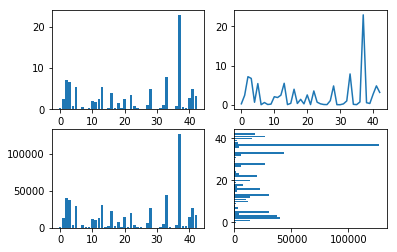

In [15]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.bar(list(idx_to_count_and_per.keys()), list(map(itemgetter(1), idx_to_count_and_per.values())))

plt.subplot(2, 2, 2)
plt.plot(list(idx_to_count_and_per.keys()), list(map(itemgetter(1), idx_to_count_and_per.values())))

plt.subplot(2, 2, 3)
plt.bar(unique, counts)

plt.subplot(2, 2, 4)
plt.barh(unique, counts)

plt.show()

(180, 240, 3)


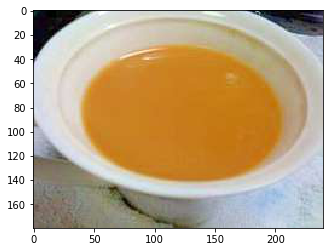

In [16]:
img = plt.imread(train_path / 'train-images/1000000965.jpg')
print(img.shape)
plt.imshow(img)

(180, 240, 3)


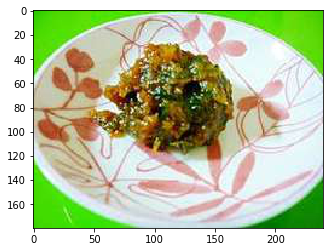

In [17]:
img = plt.imread(train_path / 'train-images/1050002320.jpg')
print(img.shape)
plt.imshow(img)

In [18]:
sizes = defaultdict(int)
count = 0

for i in (train_path / 'train-images').ls():
    i = str(i.absolute())
    img = cv2.imread(i)
    sizes[img.shape] += 1
    count += 1
    if count > 50:
        break
sizes

defaultdict(int,
            {(180, 240, 3): 26,
             (174, 240, 3): 1,
             (320, 240, 3): 10,
             (400, 240, 3): 3,
             (428, 240, 3): 1,
             (134, 240, 3): 1,
             (214, 240, 3): 1,
             (160, 240, 3): 3,
             (179, 240, 3): 2,
             (321, 240, 3): 1,
             (159, 240, 3): 1,
             (319, 240, 3): 1})

## StartifiedKFold

### Data and Utility function

In [19]:
def get_data(df, path, folder, cols, train_idx, valid_idx, size, bs):
    data = (ImageItemList.from_df(df=df, path=path, folder=folder, cols=cols)
            .split_by_idxs(train_idx, valid_idx)
            .label_from_df(cols=1)
            .transform(get_transforms(flip_vert=True), size=size)
            .databunch(bs=bs)
           ).normalize(imagenet_stats)
    
    return data

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = (self.alpha * (1 - pt) ** self.gamma) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [21]:
# weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights), data.device))

In [22]:
def top_3_accuracy(input:Tensor, targs:Tensor, top=3):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = (input.topk(top, -1)[1]).view(n, -1)
    targs = targs.view(n, -1)
    x = (input == targs)
    res = torch.zeros(n)
    for i in range(n):
        res[i] = x[i].any()
    
    return res.float().mean()

## Models

In [23]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
train_valid_indexes_list = [[i, j] for i, j in kfold.split(df['filename'].values, df['tag'].values)]

In [25]:
expected_t_len, expected_v_len = len(train_valid_indexes_list[0][0]), len(train_valid_indexes_list[0][1])

In [26]:
def validate_idx(t, v):
    t_len, v_len = len(train_idx), len(valid_idx)
    assert t_len == expected_t_len, "FAILURE, lenght of train index mismatch"
    assert v_len == expected_v_len, "FAILURE, lenght of valid index mismatch"
    
    t_set_len, v_set_len = len(set(train_idx)), len(set(valid_idx))
    assert t_set_len == expected_t_len, "FAILURE, lenght of train index set mismatch"
    assert v_set_len == expected_v_len, "FAILURE, lenght of valid index set mismatch"
    
    t_minus_v = len(set(train_idx) - set(valid_idx))
    v_minus_t = len(set(valid_idx) - set(train_idx))
    assert t_minus_v == expected_t_len, "FAILURE, lenght of train set have indexes in valid"
    assert v_minus_t == expected_v_len, "FAILURE, lenght of valid set have indexes in train"
    
    return

### Model 1

In [27]:
train_idx, valid_idx = train_valid_indexes_list[0]

In [28]:
validate_idx(train_idx, valid_idx)

In [29]:
size = 128

In [30]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, size, 300)

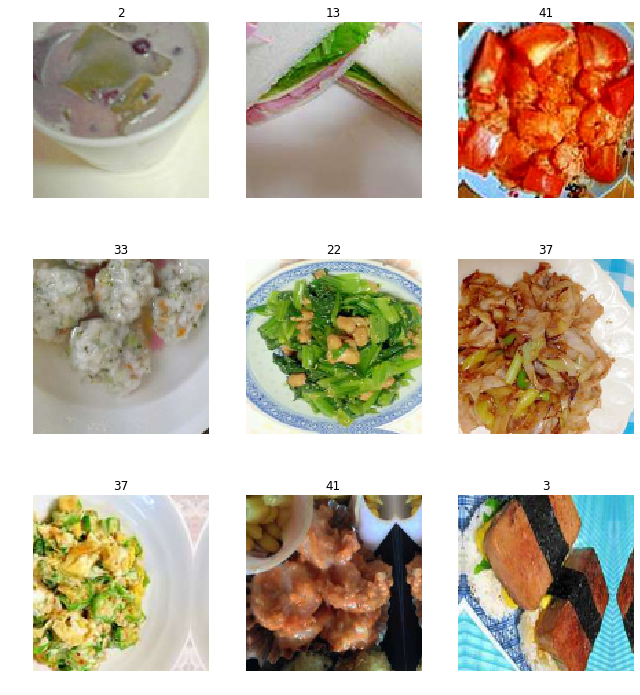

In [31]:
data.show_batch(3)

In [32]:
data.c

43

In [33]:
c2i = data.c2i
class_weights_rearrenged = [0] * 43

In [34]:
for new_idx, idx in c2i.items():
    class_weights_rearrenged[idx] = class_weights[new_idx]

In [35]:
c2i, class_weights_rearrenged, class_weights

({40: 0,
  31: 1,
  3: 2,
  37: 3,
  19: 4,
  5: 5,
  28: 6,
  42: 7,
  2: 8,
  33: 9,
  13: 10,
  20: 11,
  39: 12,
  22: 13,
  41: 14,
  1: 15,
  16: 16,
  36: 17,
  7: 18,
  27: 19,
  15: 20,
  12: 21,
  11: 22,
  10: 23,
  32: 24,
  34: 25,
  18: 26,
  17: 27,
  0: 28,
  4: 29,
  38: 30,
  35: 31,
  8: 32,
  24: 33,
  23: 34,
  25: 35,
  26: 36,
  9: 37,
  29: 38,
  6: 39,
  14: 40,
  21: 41,
  30: 42},
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.6408179637782003,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.5895765538116935,
  2.2761613316354787,
  1.0,
  1.0,
  2.359997844771224,
  3.319893341219623,
  1.193183267887127,
  4.187839312780309,
  4.626277363576803,
  3.065738827059269,
  2.7677728503472454,
  5.125915318843099],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  4.626277363576803,
  1.0,
  2.2761613316354787,
  1.193183267887127,
  1.0,
  1.0,
  

In [36]:
weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights_rearrenged), data.device))

In [37]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate, top_3_accuracy], loss_func=weighted_cross_entropy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


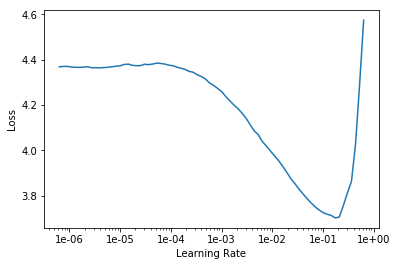

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(2, max_lr=1e-2)

Total time: 1:20:23
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      2.252893    2.200002    0.596297    0.651098        (40:18)
2      2.087650    2.021514    0.546923    0.699832        (40:04)



In [40]:
learn.save("Model1_resnet50_2epochs")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


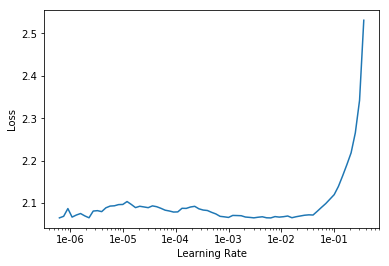

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(3, max_lr=1e-4)

Total time: 2:00:11
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      2.092130    2.016737    0.546319    0.700175        (40:03)
2      2.085369    2.011087    0.544075    0.701635        (40:04)
3      2.085613    2.013425    0.545859    0.701833        (40:03)



In [43]:
learn.save("Model1_resnet50_5epochs")

In [ ]:
# %%capture output
# learn.fit_one_cycle(3, max_lr=1e-5)
# output.show()

In [ ]:
# learn.save("Model1_resnet50_8epochs")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


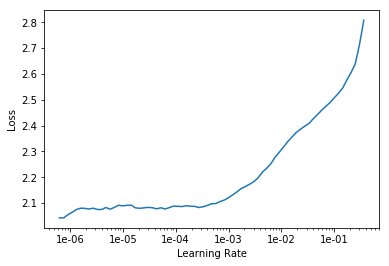

In [44]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 4:16:58
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      2.054671    1.996246    0.540677    0.706349        (51:27)
2      2.044691    1.971347    0.533241    0.712947        (51:23)
3      2.027245    1.951987    0.528347    0.716921        (51:21)
4      2.007764    1.940387    0.525165    0.720662        (51:22)
5      1.997757    1.937495    0.524083    0.722185        (51:23)



In [46]:
learn.save("stage_1")

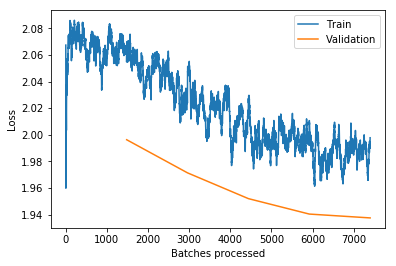

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.fit_one_cycle(10, slice(1e-7, 5e-5))

Total time: 8:31:46
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      2.000899    1.941078    0.524525    0.719995        (51:24)
2      1.981873    1.934850    0.523443    0.722059        (51:23)
3      1.967621    1.932821    0.522912    0.722194        (51:12)
4      1.974763    1.927738    0.521479    0.723943        (51:08)
5      1.966413    1.922964    0.520262    0.724781        (51:08)
6      1.957413    1.919577    0.519694    0.726151        (51:06)
7      1.940984    1.917373    0.518279    0.727269        (51:03)
8      1.970310    1.916643    0.518234    0.726683        (51:04)
9      1.952759    1.916525    0.517585    0.726926        (51:05)
10     1.984574    1.915207    0.518504    0.727476        (51:09)



In [49]:
learn.save("stage_1-final")

In [38]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, 224, 128)

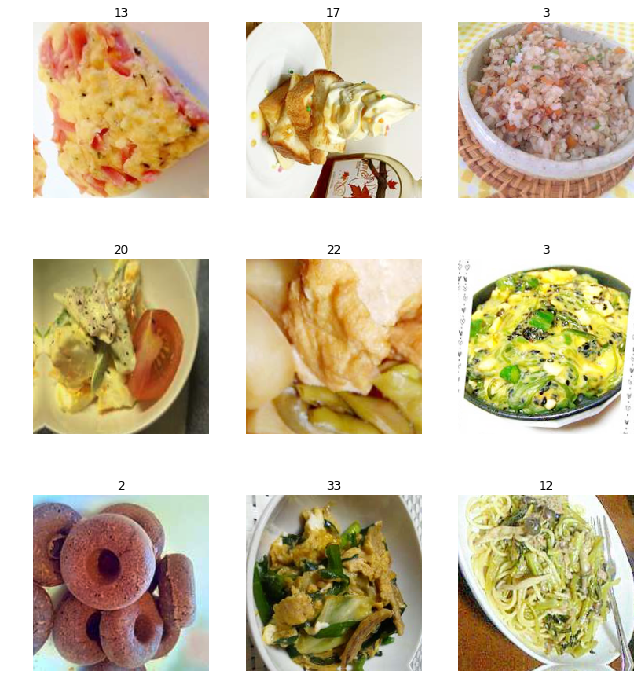

In [39]:
data.show_batch(3)

In [40]:
data.c

43

In [41]:
c2i == data.c2i

True

In [42]:
c2i

{40: 0,
 31: 1,
 3: 2,
 37: 3,
 19: 4,
 5: 5,
 28: 6,
 42: 7,
 2: 8,
 33: 9,
 13: 10,
 20: 11,
 39: 12,
 22: 13,
 41: 14,
 1: 15,
 16: 16,
 36: 17,
 7: 18,
 27: 19,
 15: 20,
 12: 21,
 11: 22,
 10: 23,
 32: 24,
 34: 25,
 18: 26,
 17: 27,
 0: 28,
 4: 29,
 38: 30,
 35: 31,
 8: 32,
 24: 33,
 23: 34,
 25: 35,
 26: 36,
 9: 37,
 29: 38,
 6: 39,
 14: 40,
 21: 41,
 30: 42}

In [43]:
data.c2i

{40: 0,
 31: 1,
 3: 2,
 37: 3,
 19: 4,
 5: 5,
 28: 6,
 42: 7,
 2: 8,
 33: 9,
 13: 10,
 20: 11,
 39: 12,
 22: 13,
 41: 14,
 1: 15,
 16: 16,
 36: 17,
 7: 18,
 27: 19,
 15: 20,
 12: 21,
 11: 22,
 10: 23,
 32: 24,
 34: 25,
 18: 26,
 17: 27,
 0: 28,
 4: 29,
 38: 30,
 35: 31,
 8: 32,
 24: 33,
 23: 34,
 25: 35,
 26: 36,
 9: 37,
 29: 38,
 6: 39,
 14: 40,
 21: 41,
 30: 42}

In [56]:
learn.freeze()
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


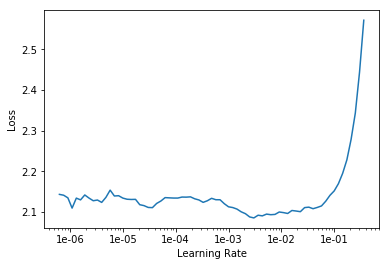

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(3, 1e-3)

Total time: 5:53:08
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      1.959251    1.868623    0.503686    0.740085        (1:57:48)
2      1.892105    1.841426    0.497909    0.746521        (1:57:36)
3      1.866012    1.830443    0.495484    0.748504        (1:57:43)



In [59]:
learn.save("resnet50_224_3epochs")

In [44]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate, top_3_accuracy], loss_func=weighted_cross_entropy)

In [46]:
_ = learn.load("resnet50_224_3epochs")

In [ ]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,error_rate,top_3_accuracy


In [49]:
learn.fit_one_cycle(1, 1e-4)

Total time: 2:05:40
epoch  train_loss  valid_loss  error_rate  top_3_accuracy
1      1.883760    1.825365    0.494051    0.749513        (2:05:40)



In [51]:
learn.save("resnet50_224_7epochs")

In [52]:
learn.unfreeze()

In [53]:
learn.fit_one_cycle(1, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,top_3_accuracy


RuntimeError: CUDA out of memory. Tried to allocate 49.00 MiB (GPU 0; 11.17 GiB total capacity; 10.72 GiB already allocated; 15.69 MiB free; 132.35 MiB cached)

In [ ]:
learn.get_preds(DatasetType.Test)

In [ ]:
data = (ImageItemList.from_df(df=df, path=path, folder=folder, cols=cols)
        .split_by_idxs(train_idx, valid_idx)
        .label_from_df(cols=1)
        .add_test_folder()
        .transform(get_transforms(flip_vert=True), size=128)
        .databunch(bs=bs)
       ).normalize(imagenet_stats)

In [ ]:
f = [o.name for o in os.scandir('/home/deep/HE/data/test/test1-images') if o.is_file()]

In [ ]:
files = [f.name for f in learn.data.test_ds.x.items]

In [ ]:
f[:5]

In [ ]:
len(f)

In [ ]:
learn.data.train_ds[0]

In [ ]:
data = ImageDataBunch.single_from_classes(
            Path('data'),
            range(43),
            tfms=get_transforms(),
            size=128,
        ).normalize(imagenet_stats)

learn.load("stage_1-18427-17607-05571-06907")

import os
import glob
from fastai.vision import open_image

img_dir = 'data/training-data/train-images' 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
results = []
n = 0
for f1 in files[:10]:
    print(f1)
    n += 1
    img = open_image(f1)
    class_, predictions, losses = learn.predict(img)
    losses = losses.numpy()
    top_3 = losses.argsort()[-3:][::-1]
    results.append([f1[-14:],str(top_3[0])+","+str(top_3[1])+","+str(top_3[2])])
#     print(len(results)/len(files))
tt = pd.DataFrame(results, columns = ['Image-Id', 'Category'])

In [ ]:
tt

In [ ]:
df[df.filename == '1490001003.jpg']

### Model 2

In [ ]:
train_idx, valid_idx = train_valid_indexes_list[2]

In [ ]:
validate_idx(train_idx, valid_idx)

In [ ]:
size = 128

In [ ]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, size, 128)

In [ ]:
data.show_batch(3)

In [ ]:
weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights), data.device))

In [ ]:
learn.save("Model2_foobar")

### Model 3

In [ ]:
train_idx, valid_idx = train_valid_indexes_list[2]

In [ ]:
validate_idx(train_idx, valid_idx)

In [ ]:
size = 128

In [ ]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, size, 128)

In [ ]:
data.show_batch(3)

In [ ]:
weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights), data.device))

In [ ]:
learn.save("Model3_foobar")

### Model 4

In [ ]:
train_idx, valid_idx = train_valid_indexes_list[3]

In [ ]:
validate_idx(train_idx, valid_idx)

In [ ]:
size = 128

In [ ]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, size, 128)

In [ ]:
data.show_batch(3)

In [ ]:
weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights), data.device))

In [ ]:
learn.save("Model4_foobar")

### Model 5

In [ ]:
train_idx, valid_idx = train_valid_indexes_list[4]

In [ ]:
validate_idx(train_idx, valid_idx)

In [ ]:
size = 128

In [ ]:
data = get_data(df, path, 'training-data/train-images', 0, train_idx, valid_idx, size, 128)

In [ ]:
data.show_batch(3)

In [ ]:
weighted_cross_entropy = partial(F.cross_entropy, weight=to_device(torch.tensor(class_weights), data.device))

In [ ]:
learn.save("Model5_foobar")